# Classification of Target Position based on Ancillary Measurements
### *Identifying our targets by what they "sound" like*

by: Bryan Dannowitz

### Problem:
Our proton beam shoots at our *target table*. The table shifts back and forth, allowing us to hit one of seven targets. For a certain range of data, we're not 100% sure what our target position was. We want to be certain before we analyze it.

### Objective:
We have many (90+) readouts of esoteric measures like *trigger rates* and radiation levels. Here, I aggregate these readouts, exclude non-useful *features*, and train a *Random Forest Classifier* to predict our target position.

### Procedure:
1. Get a full readout of *features* from our MySQL storage
2. Clean it up by removing entries from 'bad spills'
3. Exclude any non-helpful *features*
4. Train and test an RFC
5. Pickle it for daily use at our experiment

In [1]:
from os import path, remove         # Check if files exist
import MySQLdb as mdb               # Raw data source is MySQL
import pandas as pd                 # Workhorse data management tool
import numpy as np                  # For matrices, arrays, matrix math, and nan's
from math import floor

## Notebook Specifics

In [2]:
%matplotlib inline           
pd.set_option("max_rows", 10)
np.set_printoptions(precision=3)       

## Plotting, Graphics

In [3]:
import matplotlib.pyplot as plt     # For plotting some distributions
import seaborn as sns               # For easy, pretty plotting
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=1.4)

# Wrangling the data into shape

## Reading Data from MySQL

In [4]:
server = 'e906-db3.fnal.gov'                         # Source MySQL server
port = 3306
schema = 'merged_roadset62_R004_V005'                # Source MySQL schema
analysis_schema = 'user_dannowitz_target_analysis'   # A schema name for temporary storage
analysis_table = 'target_analysis'                   # A table name for that schema

In [5]:
# Aggregate data into our analysis schema and table.
# Table defined here:
create_query = """
               CREATE TABLE IF NOT EXISTS %s.%s
               (
                   spillID MEDIUMINT NOT NULL,
                   name VARCHAR(64),
                   value DOUBLE NOT NULL,
                   targetPos INT NOT NULL
                )"""

In [6]:
# Here is one MySQL query that will grab all the data we want
#     Most of this requires a bit of domain expertise to understand
#     as it's specific to our experiment's data structure
scaler_query =  """
                INSERT INTO %s.%s
                ### Get data from our Scaler table, along with the target position.
                ### This contains features from our triggering systems (data taking rates)
                
                SELECT s.spillID, scalerName AS `name`, value, targetPos
                FROM Scaler 
                INNER JOIN Spill s              # Source of targetPos
                    USING(spillID) 
                WHERE scalerName IS NOT NULL AND 
                      s.spillID NOT BETWEEN 409000 AND 430000 AND     
                      s.spillID NOT BETWEEN 416709 AND 424180 AND
                      s.spillID NOT BETWEEN 482574 AND 484924 AND
                      spillType='EOS' AND
                      s.dataQuality = 0
                """

In [7]:
beam_query = """
             INSERT INTO %s.%s
             ### Get data from our Beam table, along with the target position
             ### This contains features from our proton beam and radiation monitors

             SELECT s.spillID, name, value, targetPos 
             FROM Beam
             INNER JOIN Spill s              # Source of targetPos
                 USING(spillID)
             WHERE name IS NOT NULL AND
                 LEFT(name,3)!='F:M' AND   # Exclude features that are always NULL
                 name!='F:NM2SEM' AND      # 
                 name!='U:TODB25' AND      #
                 name!='S:KTEVTC' AND      #
                 s.spillID NOT BETWEEN 409000 AND 430000 AND
                 s.spillID NOT BETWEEN 416709 AND 424180 AND
                 s.spillID NOT BETWEEN 482574 AND 484924 AND
                 s.dataQuality = 0
             """

In [8]:
# The query for reading out the aggregated information
fetch_query = """SELECT * FROM %s.%s"""

In [9]:
# Run the query and read the resultset into a DataFrame
try:
    db = mdb.connect(read_default_file='../.my.cnf',                  # Keep my login credentials secure
                     read_default_group='guest',                   # Read-only access to important data
                     host=server,
                     db=schema,
                     port=port)
    
    cur = db.cursor()
    
    cur.execute("SHOW DATABASES LIKE '%s'" % analysis_schema)      # See if schema exists
    
    if cur.rowcount != 0:
        cur.execute("DROP DATABASE %s" % analysis_schema)          # Drop if it does
    
    cur.execute("CREATE DATABASE %s" % analysis_schema)            # Create analysis schema
    cur.execute(create_query % (analysis_schema, analysis_table))  # Create analysis table
    
    cur.execute(scaler_query % (analysis_schema, analysis_table))  # Fill table with scaler data
    cur.execute(beam_query % (analysis_schema, analysis_table))    # Fill table with beam data
    
    data_df = pd.read_sql(fetch_query %                            # Read data into DataFrame
                          (analysis_schema, analysis_table), db)

    if db:
        db.close()

except mdb.Error, e:

    print "Error %d: %s" % (e.args[0], e.args[1])

In [10]:
# Write to file, and you can read it back instead of querying again
data_df.to_csv('insight_demo_roadset62_long.csv')

In [12]:
# Write to file, and you can read it back instead of querying again
data_df = pd.read_csv('insight_demo_roadset62_long.csv', index_col='Unnamed: 0')

## Explore the Data

In [11]:
data_df.head()                   # Peek at the data

,spillID,name,value,targetPos
0,441627,AcceptedMATRIX1,2589,1
1,441627,AcceptedMATRIX2,49,1
2,441627,AcceptedMATRIX3,22,1
3,441627,AcceptedMATRIX4,16,1
4,441627,AcceptedMATRIX5,16,1


In [12]:
data_df.info()                # ...and investigate data types.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3694410 entries, 0 to 3694409
Data columns (total 4 columns):
spillID      int64
name         object
value        float64
targetPos    int64
dtypes: float64(1), int64(2), object(1)
memory usage: 140.9+ MB


## Clean the Data some more
### *Feature Exclusion*

1. Pivot the dataframe
2. Eliminate rows with missing data
3. Inspect the means and standard deviations
4. Identify the *zero standard deviation* features, as they're not helpful
5. Remove them from our pivoted dataframe and our scaler_df dataset

In [13]:
# We want to see our scalerNames as column indexes
pivoted_df = data_df.pivot('spillID', 'name', 'value'); pivoted_df.head()

name,AcceptedBOS,AcceptedEOS,AcceptedMATRIX1,AcceptedMATRIX2,AcceptedMATRIX3,AcceptedMATRIX4,AcceptedMATRIX5,AcceptedNIM1,AcceptedNIM2,AcceptedNIM3,...,RawMATRIX4,RawMATRIX5,RawNIM1,RawNIM2,RawTriggers,S:F1SEM,S:G2SEM,S:MSEP1U,TSGo,TsBusy
spillID,,,,,,,,,,,,,,,,,,,,,
430001,0,1,1606,220,14,14,12,31,0,12,...,1598521,304915,2361033,8328860,10759045,147773484,5.022777e+12,446.734375,1904,1905
430002,0,1,2341,247,19,16,14,31,0,13,...,1670878,338078,2311914,9156547,11813291,235342956,5.087022e+12,446.734375,2678,2679
430003,0,1,2341,233,20,16,15,35,0,16,...,1675869,327909,2327753,9302103,12002554,314702790,5.150387e+12,446.687500,2671,2672
430004,0,1,2317,248,19,15,14,28,0,16,...,1637602,337641,2305265,8949368,11564482,180612036,5.060495e+12,446.703125,2652,2653
430005,0,1,1533,203,13,16,12,35,0,18,...,1587623,289114,2262125,8177669,10627391,224396772,5.104749e+12,446.734375,1830,1831


### Handle missing data

In [14]:
# Replace sentinel values with NaN's and then drop those rows
pivoted_df = pivoted_df.replace(-9999,np.nan).dropna(axis=0,how='any')

In [15]:
# We take a peek to see what the values in each look like overall
pivoted_df.describe()

,AcceptedBOS,AcceptedEOS,AcceptedMATRIX1,AcceptedMATRIX2,AcceptedMATRIX3,AcceptedMATRIX4,AcceptedMATRIX5,AcceptedNIM1,AcceptedNIM2,AcceptedNIM3,...,RawMATRIX4,RawMATRIX5,RawNIM1,RawNIM2,RawTriggers,S:F1SEM,S:G2SEM,S:MSEP1U,TSGo,TsBusy
count,40951,40951,40951.000000,40951.000000,40951.000000,40951.000000,40951.000000,40951.000000,40951,40951.000000,...,40951.000000,40951.000000,40951.000000,40951.000000,40951.000000,4.095100e+04,4.095100e+04,40951.000000,40951.000000,40951.000000
mean,0,1,2544.457913,70.110132,21.456594,27.310469,21.573026,41.841713,0,17.899392,...,2339390.447706,364359.886547,2149008.467608,8730119.084564,12096416.665820,2.646751e+10,5.505983e+12,371.624283,2739.995702,2740.972748
std,0,0,482.039903,131.662513,4.603769,6.589574,5.037009,6.095684,0,1.736201,...,502128.475285,179819.547210,145900.010250,521481.997410,737011.675984,5.372721e+10,3.798618e+11,134.952897,509.452873,509.443011
min,0,1,746.000000,1.000000,5.000000,6.000000,6.000000,12.000000,0,9.000000,...,686606.000000,58155.000000,767803.000000,3174248.000000,5843118.000000,4.652128e+07,2.307905e+12,81.562500,870.000000,871.000000
25%,0,1,2217.000000,12.000000,18.000000,21.000000,18.000000,38.000000,0,17.000000,...,2008121.000000,251156.500000,2057599.000000,8436446.500000,11672054.000000,3.420682e+08,5.308673e+12,402.015625,2395.000000,2396.000000
50%,0,1,2514.000000,15.000000,21.000000,30.000000,22.000000,43.000000,0,18.000000,...,2218191.000000,292212.000000,2129868.000000,8785584.000000,12159985.000000,5.993036e+08,5.572063e+12,434.671875,2689.000000,2690.000000
75%,0,1,2839.000000,38.000000,24.000000,32.000000,25.000000,46.000000,0,19.000000,...,2582538.000000,378699.000000,2224128.000000,9085496.500000,12585684.500000,1.149349e+09,5.769700e+12,451.640625,3039.000000,3040.000000
max,0,1,5183.000000,818.000000,53.000000,45.000000,38.000000,61.000000,0,24.000000,...,4846645.000000,1807106.000000,4162679.000000,10496755.000000,15170123.000000,3.609942e+11,7.777378e+12,494.625000,5740.000000,5741.000000


### Identify *zero standard deviation* features

In [16]:
# It's sufficient to say that if the standard deviation is 0, then it's certainly not useful
zero_std_series = (pivoted_df.describe().ix['std'] == 0)
# Get an array of all the features with zero standard deviations
zero_std_features = zero_std_series[zero_std_series == True].index.values; zero_std_features

array(['AcceptedBOS', 'AcceptedEOS', 'AcceptedNIM2', 'AcceptedNIM4',
       'AcceptedNIM5', 'E:M3TGHF', 'E:M3TGHI', 'E:M3TGVF', 'E:M3TGVI',
       'F:NM3ION', 'G:BNCH13', 'G:TURN13', 'NM3SEM', 'PrescaleNIM2',
       'PrescaleNIM4', 'PrescaleNIM5', 'PrescaledBOS', 'PrescaledEOS'], dtype=object)

### Remove these from our analysis

In [17]:
# Get rid of these features
_ = pivoted_df.drop(zero_std_features, axis=1, inplace=True)

# Assemble Cleaned, Processed Data
### With data and labels, so that it's well-suited to be fed to our RFC

In [18]:
# Let's prepare the lables, or, our target positions
targpos_df = data_df[['spillID','targetPos']].drop_duplicates().sort('spillID')
targpos_df.head()

,spillID,targetPos
549780,430001,2
549824,430002,3
549868,430003,3
549912,430004,3
549956,430005,4


### Merge the data with the labels

In [19]:
full_df = pd.merge(pivoted_df, targpos_df, how='left', right_on='spillID', left_index=True)

In [20]:
full_df = full_df.set_index('spillID')
full_df.head()

name,AcceptedMATRIX1,AcceptedMATRIX2,AcceptedMATRIX3,AcceptedMATRIX4,AcceptedMATRIX5,AcceptedNIM1,AcceptedNIM3,AfterInhMATRIX1,AfterInhMATRIX2,AfterInhMATRIX3,...,RawMATRIX5,RawNIM1,RawNIM2,RawTriggers,S:F1SEM,S:G2SEM,S:MSEP1U,TSGo,TsBusy,targetPos
spillID,,,,,,,,,,,,,,,,,,,,,
430001,1606,220,14,14,12,31,12,1608,259557,1700,...,304915,2361033,8328860,10759045,147773484,5.022777e+12,446.734375,1904,1905,2
430002,2341,247,19,16,14,31,13,2344,294878,2369,...,338078,2311914,9156547,11813291,235342956,5.087022e+12,446.734375,2678,2679,3
430003,2341,233,20,16,15,35,16,2343,277955,2407,...,327909,2327753,9302103,12002554,314702790,5.150387e+12,446.687500,2671,2672,3
430004,2317,248,19,15,14,28,16,2321,296784,2412,...,337641,2305265,8949368,11564482,180612036,5.060495e+12,446.703125,2652,2653,3
430005,1533,203,13,16,12,35,18,1532,240062,1567,...,289114,2262125,8177669,10627391,224396772,5.104749e+12,446.734375,1830,1831,4


In [21]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40951 entries, 430001 to 482555
Data columns (total 73 columns):
AcceptedMATRIX1     40951 non-null float64
AcceptedMATRIX2     40951 non-null float64
AcceptedMATRIX3     40951 non-null float64
AcceptedMATRIX4     40951 non-null float64
AcceptedMATRIX5     40951 non-null float64
AcceptedNIM1        40951 non-null float64
AcceptedNIM3        40951 non-null float64
AfterInhMATRIX1     40951 non-null float64
AfterInhMATRIX2     40951 non-null float64
AfterInhMATRIX3     40951 non-null float64
AfterInhMATRIX4     40951 non-null float64
AfterInhMATRIX5     40951 non-null float64
AfterInhNIM1        40951 non-null float64
AfterInhNIM2        40951 non-null float64
E:M2C2HF            40951 non-null float64
E:M2C2HI            40951 non-null float64
E:M2C2HM            40951 non-null float64
E:M2C2HS            40951 non-null float64
E:M2C2VF            40951 non-null float64
E:M2C2VI            40951 non-null float64
E:M2C2VM            40951

In [22]:
# Write it to file for use in the next part.
full_df.to_csv('roadset62_targetPos_study.csv')

# Create, Train Random Forest From Data

In [5]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation              # We'll want to cross-validate our RF
sns.set_context("poster")

In [6]:
# If the data is already written, and we're re-visiting, 
#    just load the prepared data here
full_df = pd.read_csv('roadset62_targetPos_study.csv', index_col='spillID')

In [7]:
# Split the DataFrame up into 'data' and 'labels'
labels = full_df.values[:,-1]

## Feature Engineering
* One thing we do know in this experiment is that *'S:G2SEM'* is a measure of ***Beam Intensity***
* ***Beam Intensity*** does not depend on anything in our experiment...
* BUT many, *many* things in our experiment depend on *Beam Intensity*
* So, normalize all *features* to ***Beam Intensity*** for more robust classifier

In [8]:
# Rescale the training data to beam intensity
#    Beam intensity is a big number (O(10^12)), so multiply by a big constant
#    to bring it back up to normal feature ranges 
normed_df = pd.DataFrame( (full_df.drop('targetPos', axis=1).values / full_df[['S:G2SEM']].values) * 5000000000000.0, 
                           columns=full_df.columns[:-1] )

_ = normed_df.drop('S:G2SEM', axis=1, inplace=True)

## Feature Scaling
* Over time, these features may *drift* a little due to many, many effects
* Hopefully, the relative differences are key to differentiating targets

In [45]:
data = full_df.values[:,:-1]

In [9]:
data = normed_df.values

In [10]:
scale = StandardScaler().fit(data)

In [11]:
data_scaled = scale.transform(data)

### Split our data up into training and test sets

In [29]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data, labels, test_size=0.33, random_state=2)

In [30]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_scaled, labels, test_size=0.33, random_state=2)

### Create RFC instance

In [31]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2)

### Train on training data

In [32]:
rfc.fit(d_train, l_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [33]:
result = rfc.predict(d_test)

print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

RF prediction accuracy =  90.3%


### Create a Confusion histogram to examine prediction performance

In [12]:
def confusion(labels, results, names):
    plt.figure(figsize=(10, 10))
    
    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(labels.astype(int), results.astype(int), bins=len(names))

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(np.flipud(pts.astype(int)), index=np.flipud(names), columns=names )

    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d", cbar=False)

    _, ylabels = plt.xticks()
    _, xlabels = plt.yticks()
    plt.setp(xlabels, rotation=45)
    plt.setp(ylabels, rotation=45)
    plt.xlabel("Actual", size=22)
    plt.ylabel("Prediction", size=22)
    
    return pts

def per_target_accuracy(hist2d_pts, names):

    for i in range(len(names)):
        rowsum = np.sum(hist2d_pts.T[i])
        if rowsum>0:
            print names[i] + ":   \t" + str(round((hist2d_pts[i][i] / np.sum(hist2d_pts.T[i]))*100,2)) + "%"
        else:
            print names[i] + ":   \tN/A"

Hydrogen:   	93.57%
Empty:   	68.58%
Deuterium:   	97.93%
None:   	72.32%
Carbon:   	95.29%
Iron:   	91.61%
Tungsten:   	92.89%


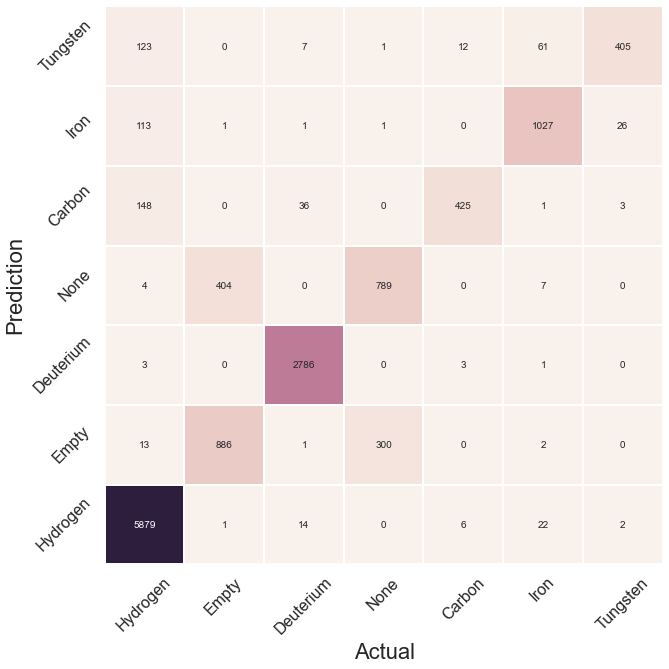

In [35]:
# Define names for the target positions
names = ['Hydrogen','Empty','Deuterium','None','Carbon','Iron','Tungsten']

pts = confusion(l_test, result, names)
per_target_accuracy(pts, names)

### Domain knowledge: "Empty" and "None" Similarity
* *"Empty"* is basically a hollow tin can
* *"None"* is no target at all
* Used to study background signals
* Will be naturally very, very similar -- and we see above that they get mistaken for each other
* We can collapse these into one category

In [13]:
def relabel(label_array):
    # Collapse target position 4 and 2 both into category 2
    # Then shift over the rest
    label_array_revised = label_array.copy()
    label_array_revised[label_array_revised == 4] = 2
    label_array_revised[label_array_revised == 5] = 4
    label_array_revised[label_array_revised == 6] = 5
    label_array_revised[label_array_revised == 7] = 6
    
    return label_array_revised

In [14]:
# Call the new re-labelling function
#    and modify the names array
labels_revised = relabel(labels)
names = ['Hydrogen','Empty/None','Deuterium','Carbon','Iron','Tungsten']

In [15]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_scaled, labels_revised, test_size=0.33, random_state=5)

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(d_train, l_train)

result = rfc.predict(d_test)
print("RF prediction accuracy = {0:5.1f}%\n".format(100.0 * rfc.score(d_test, l_test)))

RF prediction accuracy =  95.8%



Hydrogen:   	93.76%
Empty/None:   	99.38%
Deuterium:   	98.17%
Carbon:   	97.76%
Iron:   	95.07%
Tungsten:   	89.39%


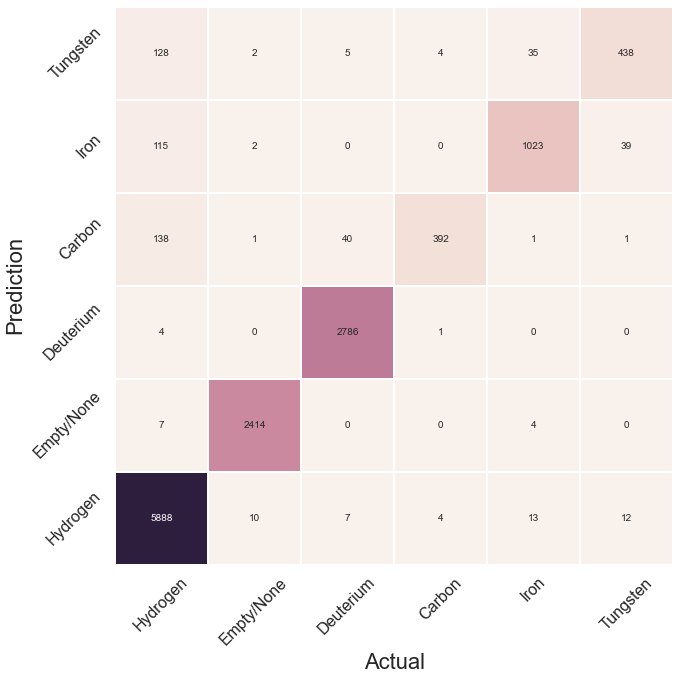

In [16]:
pts = confusion(l_test, result, names)   # Show confusion matrix
per_target_accuracy(pts, names)          # Print per-target accuracy

# Most Valuable Features
* Rank our top most valuable features
* See if any make obvious sense
* Perhaps use only useful features in future iterations

In [17]:
features = full_df.drop(['S:G2SEM','targetPos'], axis=1).columns.values
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

useful_feature_list = []
for f in range(20):
    print("%d. Feature '%s' (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    useful_feature_list.append(features[indices[f]])

Feature ranking:
1. Feature 'G:RD3161' (0.096497)
2. Feature 'AfterInhMATRIX5' (0.081609)
3. Feature 'G:RD3162' (0.075144)
4. Feature 'PrescaleMATRIX5' (0.072497)
5. Feature 'RawMATRIX4' (0.056967)
6. Feature 'RawTriggers' (0.043715)
7. Feature 'RawMATRIX5' (0.043319)
8. Feature 'AfterInhMATRIX3' (0.036605)
9. Feature 'PrescaledTrigger' (0.028029)
10. Feature 'PrescaleMATRIX3' (0.026866)
11. Feature 'AfterInhMATRIX4' (0.023046)
12. Feature 'TsBusy' (0.021676)
13. Feature 'PrescaleMATRIX1' (0.021607)
14. Feature 'TSGo' (0.020898)
15. Feature 'PrescaleMATRIX2' (0.020148)
16. Feature 'PrescaleMATRIX4' (0.018129)
17. Feature 'RawMATRIX2' (0.017642)
18. Feature 'AfterInhNIM2' (0.016969)
19. Feature 'AcceptedMATRIX5' (0.016335)
20. Feature 'AfterInhMATRIX2' (0.016152)


## Train on *useful*, vetted, approved features
* Time-invariant (always been read out, always will be read out)for the experiment
* Ensures that our RFC can be used on past and future data

In [18]:
reduced_df = pd.DataFrame( (full_df[useful_feature_list].values / full_df[['S:G2SEM']].values) * 5000000000000.0, 
                              columns=useful_feature_list )
data_reduced = reduced_df.values
scale_reduced = StandardScaler().fit(data_reduced)
data_reduced_scaled = scale_reduced.transform(data_reduced)

RF prediction accuracy =  95.8%
Hydrogen:   	94.47%
Empty/None:   	99.42%
Deuterium:   	97.76%
Carbon:   	93.43%
Iron:   	94.09%
Tungsten:   	88.27%


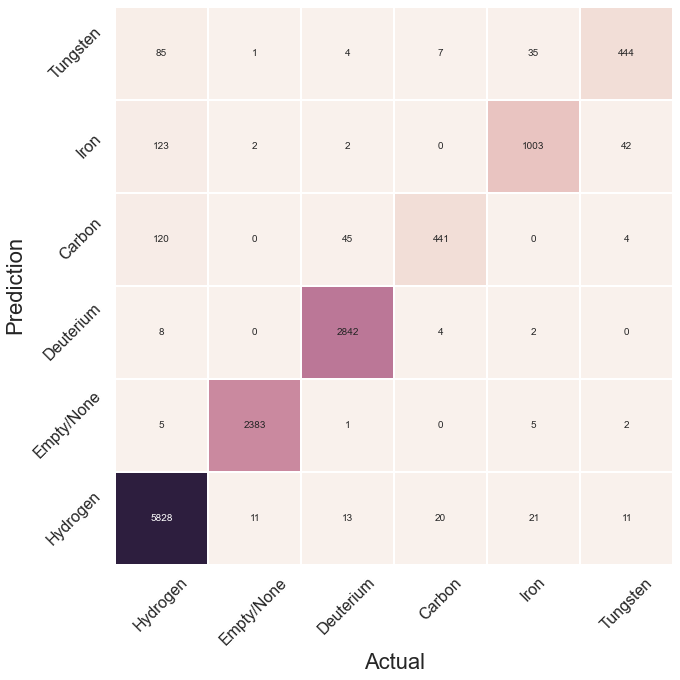

In [43]:
# We've reduced the number of features and normalized them all to beam intensity
# Let's see how that's affected our predictor

d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_reduced_scaled, labels_revised, test_size=0.33, random_state=6)
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(d_train, l_train)
result = rfc.predict(d_test)
print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

pts = confusion(l_test, result, names)
per_target_accuracy(pts, names)

# Cross-Validation
* Let us exhaustively check how robust the RFC is
* We do this by cross-validation using the whole data set
* Randomly split the data into 10 *folds* using KFold

In [44]:
kf_total = cross_validation.StratifiedKFold(labels_revised, n_folds=10, shuffle=True, random_state=4)
rfc_scores = cross_validation.cross_val_score(rfc, data_reduced_scaled, labels_revised, cv=kf_total)

In [45]:
print "RFC Scores: ", rfc_scores
print "Accuracy: %0.2f (+/- %0.2f)" % (rfc_scores.mean(), rfc_scores.std() * 2)

RFC Scores:  [ 0.959  0.964  0.966  0.961  0.959  0.961  0.963  0.961  0.963  0.961]
Accuracy: 0.96 (+/- 0.00)


# Looks Good!
* Let's put together our official Train and Test data sets!
* We'll need to pull the data for the range of questionable target position
* We'll also need to parse apart the run log file to extract the labels

In [19]:
import re

In [20]:
# Go ahead and train the RFC using the whole, well-labelled data set
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(data_reduced_scaled, labels_revised)

In [21]:
# Parse apart the run log file
with open('run3.log.snip','r') as f:
    log_lines = f.readlines()
match_list = []
p = re.compile("^(\d+) nominal running conditions, physics run with (\w+)")
for line in log_lines:
    m = p.match(line)
    if m:
        match_list.append(m)
run_target_dict = { m.groups()[0] : m.groups()[1] for m in match_list }

In [22]:
# Yuck! Mispellings, differet cases, symbolic terms, etc. We need to clean this up.
# Get the distinct set of names given
target_set = set()
for run, target in run_target_dict.iteritems():
    target_set.add(target)
target_set

{'C',
 'Deuterium',
 'Fe',
 'Hydrogen',
 'W',
 'carbon',
 'deuterium',
 'dueterium',
 'empty',
 'hydrogen',
 'iron',
 'no',
 'tungsten'}

In [23]:
# Create a map of these names to the target position
target_map = {'C' : 6,
              'carbon' : 6,
              'Deuterium' : 3,
              'deuterium' : 3,
              'dueterium' : 3,
              'hydrogen' : 1,
              'Hydrogen' : 1,
              'Fe' : 5,
              'iron' : 5,
              'W' : 7,
              'tungsten' : 7,
              'no' : 4,
              'empty' : 2 }
# Update the dictionary accordingly
for run, target in run_target_dict.iteritems():
    run_target_dict[run] = target_map[target]

In [32]:
# Aggregate data into our analysis schema and table.
# Table defined here:
drop_test_table = """
                  DROP TABLE IF EXISTS %s.%s
                  """

In [24]:
# Aggregate data into our analysis schema and table.
# Table defined here:
create_test_query = """
                    CREATE TABLE IF NOT EXISTS %s.%s
                    (
                        runID MEDIUMINT NOT NULL,
                        spillID MEDIUMINT NOT NULL,
                        name VARCHAR(64),
                        value DOUBLE NOT NULL,
                        targetPos INT NOT NULL
                    )
                    """

In [40]:
# Here is one MySQL query that will grab all the data we want
#     Most of this requires a bit of domain expertise to understand
#     as it's specific to our experiment's data structure
scaler_test_query =  """
                INSERT INTO %s.%s
                ### Get data from our Scaler table, along with the target position.
                ### This contains features from our triggering systems (data taking rates)
                
                SELECT s.runID, s.spillID, scalerName AS `name`, value, targetPos
                FROM Scaler 
                INNER JOIN Spill s              # Source of targetPos
                    USING(spillID) 
                WHERE scalerName IS NOT NULL AND 
                      s.spillID BETWEEN 416709 AND 424180 AND
                      spillType='EOS' AND
                      s.dataQuality & ~(1<<26) = 0
                """

In [41]:
beam_test_query = """
             INSERT INTO %s.%s
             ### Get data from our Beam table, along with the target position
             ### This contains features from our proton beam and radiation monitors

             SELECT s.runID, s.spillID, name, value, targetPos 
             FROM Beam
             INNER JOIN Spill s              # Source of targetPos
                 USING(spillID)
             WHERE name IS NOT NULL AND
                 LEFT(name,3)!='F:M' AND   # Exclude features that are always NULL
                 name!='F:NM2SEM' AND      # 
                 name!='U:TODB25' AND      #
                 name!='S:KTEVTC' AND      #
                 s.spillID BETWEEN 416709 AND 424180 AND
                 s.dataQuality & ~(1<<26) = 0
             """

In [42]:
# The query for reading out the aggregated information
fetch_query = """SELECT * FROM %s.%s"""

In [43]:
# Run the query and read the resultset into a DataFrame
try:
    db = mdb.connect(read_default_file='../.my.cnf',               # Keep my login credentials secure
                     read_default_group='guest',                   # Read-only access to important data
                     host=server,
                     db=schema,
                     port=port)
    
    cur = db.cursor()
    
    cur.execute(drop_test_table % (analysis_schema, analysis_table + '_test'))  # Create analysis table
    cur.execute(create_test_query % (analysis_schema, analysis_table + '_test'))  # Create analysis table
    cur.execute(scaler_test_query % (analysis_schema, analysis_table + '_test'))  # Fill table with scaler data
    cur.execute(beam_test_query % (analysis_schema, analysis_table + '_test'))    # Fill table with beam data
    
    # Read data into DataFrame
    test_df = pd.read_sql(fetch_query % (analysis_schema, analysis_table + '_test'), db)

    if db:
        db.close()

except mdb.Error, e:

    print "Error %d: %s" % (e.args[0], e.args[1])

In [44]:
test_df.head()

,runID,spillID,name,value,targetPos
0,11350,416709,AcceptedMATRIX1,1348,4
1,11350,416709,AcceptedMATRIX2,86,4
2,11350,416709,AcceptedMATRIX3,11,4
3,11350,416709,AcceptedMATRIX4,14,4
4,11350,416709,AcceptedMATRIX5,11,4


In [60]:
print len(test_df.runID.unique())
print len(run_target_dict)

89
89


In [54]:
runs_to_remove = []
for run in run_target_dict:
    if int(run) not in test_df.runID.unique():
        runs_to_remove.append(run)
for run in runs_to_remove:
    run_target_dict.pop(run)

11378
11363
11442
11441
11440
11351
11355
11455
11456
11457
11452
11421
11420
11392
11391
11434
11407
11402
11408


In [57]:
runs_to_remove = []
for run in test_df.runID.unique():
    if str(run) not in run_target_dict:
        runs_to_remove.append(run)
test_df = test_df.query('runID not in @runs_to_remove').copy()

In [60]:
print len(test_df.runID.unique())
print len(run_target_dict)

89
89


In [45]:
pivoted_df = test_df.pivot('spillID', 'name', 'value')
pivoted_df = pivoted_df.replace(-9999,np.nan).dropna(axis=0,how='any')
zero_std_series = (pivoted_df.describe().ix['std'] == 0)
zero_std_features = zero_std_series[zero_std_series == True].index.values
_ = pivoted_df.drop(zero_std_features, axis=1, inplace=True)

In [46]:
pivoted_df[useful_feature_list].head()

name,G:RD3161,AfterInhMATRIX5,G:RD3162,PrescaleMATRIX5,RawMATRIX4,RawTriggers,RawMATRIX5,AfterInhMATRIX3,PrescaledTrigger,PrescaleMATRIX3,AfterInhMATRIX4,TsBusy,PrescaleMATRIX1,TSGo,PrescaleMATRIX2,PrescaleMATRIX4,RawMATRIX2,AfterInhNIM2,AcceptedMATRIX5,AfterInhMATRIX2
spillID,,,,,,,,,,,,,,,,,,,,
416709,4.35,26976,7.35,11,1041762,9204850,150481,1456,1529,11,382481,1520,1348,1519,86,14,100427,4974710,11,100427
416710,4.20,25163,7.20,10,1107556,8903347,170776,1312,1430,11,357740,1419,1238,1418,102,14,119928,4640709,10,119928
416711,4.20,26892,7.35,11,1108251,9347469,168507,1459,1603,12,374561,1594,1406,1593,101,15,117721,4885878,11,117722
416712,4.35,27050,7.35,11,1066804,9308605,160303,1398,1574,11,381321,1565,1381,1564,96,15,111842,4978495,11,111842
416713,4.35,27043,7.50,12,1090884,9239172,160791,1387,1519,12,379791,1503,1329,1502,94,15,109680,4906191,12,109681
